In [ ]:
import sys
import os
build_path = os.path.join(os.getcwd(), "..", "build")
!cmake -B {build_path} -DPYTHON_EXECUTABLE={sys.executable} -Wno-dev -DCMAKE_BUILD_TYPE=Release ..
!cmake --build {build_path} -t pypumila

In [2]:
os.chdir(build_path)
import pumila
# to reload pypumila, restart python kernel.
# importlib.reload(pypumila) <- does not work

import numpy as np
from tqdm.notebook import tqdm
import random
import matplotlib
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import count
import math

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [5]:
# if GPU is to be used
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
if device is None and torch.backends.mps.is_built():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        print("MPS not available because the current PyTorch install was not built with MPS enabled.")
if device is None and torch.backends.mkldnn.is_available():
    device = torch.device("mkldnn")
if device is None:
    device = torch.device("cpu")
print(device)

mps


In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [7]:
policy_net = pumila.Net14().to(device)
target_net = pumila.Net14().to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [8]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = pumila.ReplayMemory(10000)

In [9]:
steps_done = 0

def select_action(feat: np.ndarray):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(feat).max(0).indices.view(1, 1)
    else:
        return torch.tensor([[random.randint(0, 21)]], device=device, dtype=torch.long)

In [10]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    batch = memory.sample(BATCH_SIZE)
    if len(batch) < BATCH_SIZE:
        return

    state_batch = [s[0] for s in batch]
    feat_batch = np.vstack([s[1] for s in batch])
    reward_batch = torch.cat([torch.from_numpy(policy_net.reward(s[0])) for s in batch])
    reward_batch_1 = reward_batch

    feat_batch = torch.from_numpy(policy_net.transpose(feat_batch))
    for i in range(21):
        reward_batch = torch.stack([reward_batch, reward_batch_1])

    state_action_values = policy_net(state_batch)

    next_state_values = torch.cat([target_net(st.next()).max(0).indices.view(1, 1) for st in state_batch])
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

Complete


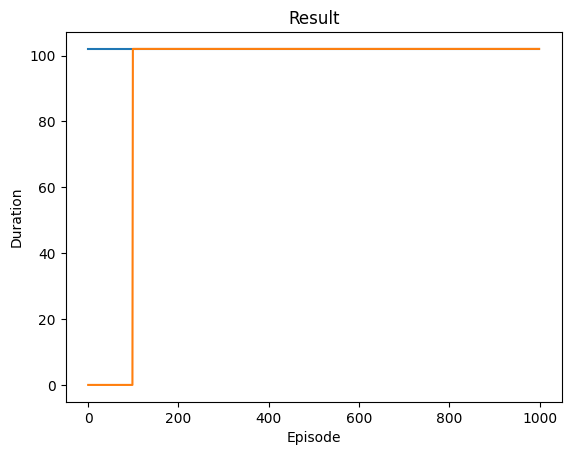

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
num_episodes = 1000
num_step = 100

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    sim = pumila.GameSim()
    num_s = 0
    for t in count():
        step = sim.current_step()
        feat = torch.from_numpy(policy_net.calc_action(step)).to(torch.float32).to(device)
        action = select_action(feat)

        sim.put(pumila.actions[action])
        memory.push(step, feat)

        while sim.phase_get() != pumila.GameSim.PhaseEnum.free:
            sim.step()
        
        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if sim.is_over or num_s > num_step:
            episode_durations.append(t + 1)
            # plot_durations()
            break
        num_s += 1

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [15]:
torch.save(policy_net, "pumila14.pt")

In [13]:
win = pumila.Window()
sim = pumila.GameSim()
win.set_sim([(sim, False)])

In [14]:
import time
while True:
    time.sleep(0.016)
    if sim.phase_get() == pumila.GameSim.PhaseEnum.free:
        step = sim.current_step()
        feat = torch.from_numpy(policy_net.calc_action(step)).to(torch.float32).to(device)
        action = select_action(feat)
        sim.soft_put(pumila.actions[action])
    sim.step()
    win.step()

IndexError: array::at

In [16]:
sim.reset()

AttributeError: 'pypumila.GameSim' object has no attribute 'reset'